## Imports

In [250]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score,balanced_accuracy_score
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.metrics import confusion_matrix
import xgboost as xgb
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from imblearn.ensemble import BalancedRandomForestClassifier
import requests
from bs4 import BeautifulSoup
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import dask.dataframe as dd

In [251]:
pd.set_option('display.max_rows', None)

In [252]:
df=pd.read_csv('Watches.csv')

/var/folders/5q/f280wjd15s56_y9s5ntbx3rw0000gn/T/ipykernel_53983/3990443208.py:1: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('Watches.csv')


In [253]:
df.drop(columns="Unnamed: 0", inplace=True)

## Dataset Information

### Columns types

In [254]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284491 entries, 0 to 284490
Data columns (total 13 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   name       211906 non-null  object
 1   price      284085 non-null  object
 2   brand      284360 non-null  object
 3   model      254025 non-null  object
 4   ref        241339 non-null  object
 5   mvmt       87806 non-null   object
 6   casem      120220 non-null  object
 7   bracem     109595 non-null  object
 8   yop        284357 non-null  object
 9   cond       208504 non-null  object
 10  sex        188686 non-null  object
 11  size       260894 non-null  object
 12  condition  71569 non-null   object
dtypes: object(13)
memory usage: 28.2+ MB


All the columns have an object format. We will need to modify it.

### NaN

In [255]:
df.isna().sum()

name          72585
price           406
brand           131
model         30466
ref           43152
mvmt         196685
casem        164271
bracem       174896
yop             134
cond          75987
sex           95805
size          23597
condition    212922
dtype: int64

All the columns contain NaN. We will deal with it later

## Reordering columns

### Drop duplicates

In [256]:
df = df.drop_duplicates()

## Deal with special values

### In model column

In [257]:
df['Model'] = df['model'].fillna('None').astype(str) + ', ' + df['brand'].fillna('None').astype(str)

### In price column

We need to remove the '$' from price column, and convert it in numerical values.

In [258]:
def extract_price(x):
    try:
        return int(str(x).lstrip('$').replace(',',''))
    except:
        pass
df['price'] = df['price'].apply(extract_price)

In [259]:
df = df[df['price']>0]

In [260]:
df['log10_price'] = df['price'].apply(lambda x: np.log10(x))

### In size column

In [261]:
df['size'] = df['size'].apply(lambda x: str(x).replace('Approximate ', '').replace('weight ', '').replace(': ', '').replace('total ', '').replace('product ', '').split()[0].rstrip('mm'))
def group_size(x):
    try:
        return str(round(float(x)))
    except:
        return 'None'
df['size'] = df['size'].apply(group_size)

### In yop column

Some years contain 'Approximation', which has to be removed.

In [262]:
df['yop'] = df['yop'].str.replace('(Approximation)', '')

In [263]:
df=df[df['yop']!='Unknown']

In [264]:
def convertir_derniere_valeur_en_float(chaine):
    if isinstance(chaine, float):
        return chaine
    else:
        valeurs = chaine.split(', ')
        derniere_valeur = valeurs[-1]
        return float(derniere_valeur)

df['yop'] = df['yop'].apply(convertir_derniere_valeur_en_float)

In [265]:
df['yop'] = df['yop'].astype('float')

### Instead of year, let's take the "age" of the product

In [266]:
df['yop'].unique()

array([2019., 2012., 2022., 2018., 2016., 2015., 2014., 2021., 2017.,
       2005., 2006., 2023., 2002., 2004., 1994., 2020., 2013., 2007.,
       2008., 1929., 2011., 2010., 1977., 2003., 1999., 1960., 1990.,
       1980., 2009., 1976., 2000., 1989., 1982., 1975., 1970., 1995.,
       1998., 1996., 1979., 1986., 1950., 1967., 1997., 1981., 2001.,
       1955., 1991., 1992., 1983., 1985., 1984., 1993., 1988., 1978.,
       1987., 1971., 1969., 1972., 1974., 1973., 1962., 1965., 1968.,
       1948., 1961., 1952., 1956., 1886., 1920., 1958., 1945., 1941.,
       1966., 1910., 1905., 1940., 1928., 1957., 1964., 1884., 1959.,
       1963., 1946., 1947., 1944., 1953., 1951., 1954., 1949., 1750.,
       1930., 1942., 1741., 1935., 1924., 1899., 1881., 1900., 1921.,
       1915., 1922., 1908., 1937., 1890., 1898., 1911., 1912., 1943.,
       1927., 1894., 1916., 1906., 1914., 1925., 1936., 1907., 1917.,
       1892., 1938., 1923., 1903., 1931., 1926., 1913., 1885., 1939.,
       1888., 1933.,

In [267]:
df['Age']=2024-df['yop']

In [268]:
df.head()

,name,price,brand,model,ref,mvmt,casem,bracem,yop,cond,sex,size,condition,Model,log10_price,Age
0,Audemars Piguet Royal Oak Offshore Chronograph...,43500.0,Audemars Piguet,Royal Oak Offshore Chronograph,26237ST.OO.1000ST.01,NaN,NaN,NaN,2019.0,Unworn,Men's watch/Unisex,42,NaN,"Royal Oak Offshore Chronograph, Audemars Piguet",4.638489,5.0
1,Audemars Piguet Royal Oak Selfwinding\n39mm Bl...,71500.0,Audemars Piguet,Royal Oak Selfwinding,15300ST.OO.1220ST.02,NaN,NaN,NaN,2012.0,Very good,Men's watch/Unisex,39,NaN,"Royal Oak Selfwinding, Audemars Piguet",4.854306,12.0
3,Audemars Piguet Royal Oak Chronograph\nSelfwin...,108000.0,Audemars Piguet,Royal Oak Chronograph,26715ST.OO.1356ST.01,Automatic,Steel,Steel,2022.0,New,Men's watch/Unisex,38,NaN,"Royal Oak Chronograph, Audemars Piguet",5.033424,2.0
5,Audemars Piguet Royal Oak Offshore Diver\n2018...,41000.0,Audemars Piguet,Royal Oak Offshore Diver,15710ST.OO.A051CA.01,Automatic,Steel,Rubber,2018.0,Unworn,Men's watch/Unisex,42,NaN,"Royal Oak Offshore Diver, Audemars Piguet",4.612784,6.0
6,Audemars Piguet Royal Oak Offshore Diver Chron...,43500.0,Audemars Piguet,Royal Oak Offshore Diver Chronograph,26703ST.OO.A051CA.01,Automatic,Steel,Rubber,2016.0,Very good,Men's watch/Unisex,42,NaN,"Royal Oak Offshore Diver Chronograph, Audemars...",4.638489,8.0


### Fill NaN in the mvmt column

We need NaN values to be replaced by valid values in the column mvmt. We assume that a unique value of name corresponds to a unique product. In this case, the product features should always be the same. Therefore, we start by retrieving the names of products for which the column mvmt contains at least one NaN value.

In [269]:
names=pd.DataFrame(df[df['mvmt'].isnull()]['name'])

We will now isolate those rows containing a product name for which 'mvmt' contains at least one null value into a dataframe. We select two columns: the product name and the associated 'mvmt' value.

In [270]:
filtered_mvmt = df[df['name'].isin(names['name'])][['name','mvmt']]

We remove the rows where the 'mvmt' value is NaN. We only want valid values to match our dataframe later on.

In [271]:
filtered_mvmt.dropna(subset=['mvmt'],inplace=True)

We create a new column in df. This new column provides the non-NaN values associated with each product name for which we have at least one NaN value associated in the 'mvmt' column.

In [272]:
df = pd.merge(df, filtered_mvmt, on='name', how='inner')

We fill the NaN values of mvmt with the non-NaN values corresponding to the same name.

In [273]:
df['mvmt_x']=df['mvmt_x'].fillna(df['mvmt_y'])

### Fill NaN in the casem column

In [274]:
names=pd.DataFrame(df[df['casem'].isnull()]['name'])

In [275]:
filtered_casem = df[df['name'].isin(names['name'])][['name','casem']]

In [276]:
filtered_casem.dropna(subset=['casem'],inplace=True)

In [277]:
filtered_casem = filtered_casem.drop_duplicates()

In [278]:
df = pd.merge(df, filtered_casem, on='name', how='inner')

In [279]:
df['casem_x']=df['casem_x'].fillna(df['casem_y'])

### Fill NaN in the bracem column

In [280]:
names=pd.DataFrame(df[df['bracem'].isnull()]['name'])

In [281]:
filtered_bracem = df[df['name'].isin(names['name'])][['name','bracem']]

In [282]:
filtered_bracem.dropna(subset=['bracem'],inplace=True)

In [283]:
filtered_bracem = filtered_bracem.drop_duplicates()

In [284]:
df = pd.merge(df, filtered_bracem, on='name', how='inner')

In [285]:
df['bracem_x']=df['bracem_x'].fillna(df['bracem_y'])

### Removing unnecessary columns

In [286]:
df = df.drop(columns=(['ref','condition','mvmt_y','casem_y','bracem_y']))

In [287]:
df=df.rename(columns={'mvmt_x':'Movement','casem_x':'Material','bracem_x':'Strap Material'})

In [288]:
df['Material'].unique()

array(['Steel', 'Titanium', 'Rose gold', 'Ceramic', 'White gold',
       'Gold/Steel', 'Carbon', 'Yellow gold', 'Red gold', 'Platinum',
       'Plastic', 'Bronze', 'Silver', 'Tantalum', 'Aluminum'],
      dtype=object)

### Estimated price per gram of material

In [289]:
price_per_gram = {
    'Steel': 0.05,
    'Titanium': 0.50,
    'Rose gold': 35,
    'White gold': 40,
    'Ceramic': 1,
    'Yellow gold': 45,
    'Gold/Steel': 2,
    'Carbon': 0.20,
    'Red gold': 40,
    'Platinum': 50,
    'Plastic': 0.01,
    'Bronze': 0.05,
    'Silver': 0.50,
    'Tantalum': 500,
    'Aluminum': 0.01
}

In [290]:
df['Material']=df['Material'].map(price_per_gram)

In [291]:
df=df.rename(columns={'Material':'Material Unit Price'})

In [292]:
df['Material Unit Price'] = df['Material Unit Price'].apply(lambda x: np.log10(x))

### Estimated price per gram of strap material

In [293]:
df['Strap Material'].unique()

array(['Steel', 'Rubber', 'Crocodile skin', 'Rose gold', 'Gold/Steel',
       'Ceramic', 'Leather', 'Titanium', 'Yellow gold', 'White gold',
       'Platinum', 'Textile', 'Red gold', 'Calf skin', 'Lizard skin',
       'Silver', 'Satin', 'Snake skin', 'Ostrich skin', 'Plastic',
       'Silicon'], dtype=object)

In [294]:
price_per_gram_strap = {
    'Steel': 0.05,
    'Rubber': 0.01,
    'Rose gold': 35,
    'Crocodile skin': 500,
    'White gold': 40,
    'Ceramic': 1,
    'Yellow gold': 45,
    'Gold/Steel': 2,
    'Titanium': 0.50,
    'Leather': 0.10,
    'Platinum': 50,
    'Calf skin': 300,
    'Textile': 0.20,
    'Red gold': 40,
    'Lizard skin': 250,
    'Silver': 0.50,
    'Satin': 5,
    'Snake skin': 200,
    'Ostrich skin': 400,
    'Plastic': 0.01,
    'Silicon': 0.05
}

In [295]:
df['Strap Material']=df['Strap Material'].map(price_per_gram_strap)

In [296]:
df=df.rename(columns={'Strap Material':'Strap Material Unit Price'})

In [297]:
df['Strap Material Unit Price'] = df['Strap Material Unit Price'].apply(lambda x: np.log10(x))

## Prepare df for the model

### Drop duplicates

In [298]:
df = df.drop_duplicates()

### Drop NaN

In [299]:
df = df.dropna()

### Keep only the most significant columns

In [300]:
df.head()

,name,price,brand,model,Movement,Material Unit Price,Strap Material Unit Price,yop,cond,sex,size,Model,log10_price,Age
0,Audemars Piguet Royal Oak Chronograph\nSelfwin...,108000.0,Audemars Piguet,Royal Oak Chronograph,Automatic,-1.30103,-1.30103,2022.0,New,Men's watch/Unisex,38,"Royal Oak Chronograph, Audemars Piguet",5.033424,2.0
1,Audemars Piguet Royal Oak Offshore Chronograph...,37800.0,Audemars Piguet,Royal Oak Offshore Chronograph,Automatic,-0.30103,-2.00000,2019.0,Very good,Men's watch/Unisex,42,"Royal Oak Offshore Chronograph, Audemars Piguet",4.577492,5.0
4,Audemars Piguet Royal Oak Dual Time\n26120ST.O...,32182.0,Audemars Piguet,Royal Oak Dual Time,Automatic,-1.30103,-1.30103,2015.0,Good,Men's watch/Unisex,39,"Royal Oak Dual Time, Audemars Piguet",4.507613,9.0
9,Audemars Piguet Royal Oak\n15500ST.OO.1220ST.01,77156.0,Audemars Piguet,Royal Oak,Automatic,-1.30103,-1.30103,2021.0,Good,Men's watch/Unisex,41,"Royal Oak, Audemars Piguet",4.887370,3.0
10,Audemars Piguet Royal Oak\n15500ST.OO.1220ST.01,77156.0,Audemars Piguet,Royal Oak,Automatic,-1.30103,-2.00000,2021.0,Good,Men's watch/Unisex,41,"Royal Oak, Audemars Piguet",4.887370,3.0


In [301]:
df.columns

Index(['name', 'price', 'brand', 'model', 'Movement', 'Material Unit Price',
       'Strap Material Unit Price', 'yop', 'cond', 'sex', 'size', 'Model',
       'log10_price', 'Age'],
      dtype='object')

In [303]:
df=df[['Model','Age','sex','size','Material Unit Price','Strap Material Unit Price','Movement','cond','log10_price']]

### Log price becomes the new price

In [304]:
df=df.rename(columns={'log10_price':'Price'})

### Size becomes float

In [305]:
df=df[df['size']!='None']

In [306]:
df['size']=df['size'].astype('float')

### Convert string into categories

In [307]:
string = ['Model','sex','Movement','cond']

In [308]:
for col in df.columns:
    if col in string:
        encoder = LabelEncoder()
        df[col] = encoder.fit_transform(df[col])

## Correlation matrix

In [309]:
df.dtypes

Model                          int64
Age                          float64
sex                            int64
size                         float64
Material Unit Price          float64
Strap Material Unit Price    float64
Movement                       int64
cond                           int64
Price                        float64
dtype: object

In [310]:
correlation_matrix = df.corr()

In [311]:
correlation_matrix

,Model,Age,sex,size,Material Unit Price,Strap Material Unit Price,Movement,cond,Price
Model,1.000000,0.136202,-0.062993,0.002059,-0.024080,0.014123,0.033571,0.009603,0.104136
Age,0.136202,1.000000,-0.050233,-0.022838,-0.073323,-0.030913,0.124957,-0.014103,-0.158338
sex,-0.062993,-0.050233,1.000000,-0.177880,0.116650,0.107990,0.260290,-0.067017,-0.096773
size,0.002059,-0.022838,-0.177880,1.000000,-0.023765,-0.029727,-0.075119,0.004604,0.044199
Material Unit Price,-0.024080,-0.073323,0.116650,-0.023765,1.000000,0.276595,0.000974,0.004795,0.338418
Strap Material Unit Price,0.014123,-0.030913,0.107990,-0.029727,0.276595,1.000000,-0.008929,0.007377,0.134893
Movement,0.033571,0.124957,0.260290,-0.075119,0.000974,-0.008929,1.000000,-0.021207,-0.199516
cond,0.009603,-0.014103,-0.067017,0.004604,0.004795,0.007377,-0.021207,1.000000,0.086198
Price,0.104136,-0.158338,-0.096773,0.044199,0.338418,0.134893,-0.199516,0.086198,1.000000


<Axes: >

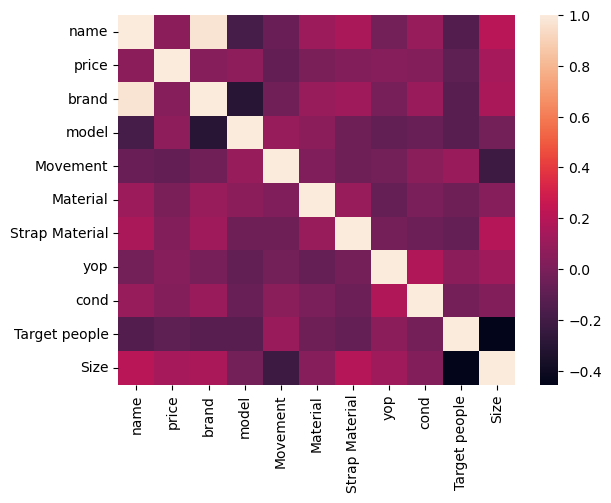

In [75]:
sns.heatmap(correlation_matrix)

In [312]:
df.to_csv('df.csv')